# Programming Assignment #3: Convolutional Networks
Author: Pierre Nugues

<h2>Objectives</h2>

The objectives of this assignment are to:
* Write a program to recognize flowers on images
* Learn how to manage an image data set
* Apply convolutional networks to images
* Know what Python generators are
* Understand class activation
* Write a short report on your experiments. This report is mandatory to pass the assignment.

## Organization

Each group will have to:
* Write Python programs to recognize the sort of flower in an image.
* Experiment different neural architectures and compare the results.

Each student will have to:
* Run at home Chollet's notebook: `5.4-visualizing-what-convnets-learn.ipynb`. The version available here https://github.com/fchollet/deep-learning-with-python-notebooks does not work with TensorFlow 2. Use the implementation available here: https://github.com/pnugues/edan95/tree/master/labs instead.
* Write an individual report on these experiments.

While not compulsory, I highly recommend that you use Google colab and run your program on a GPU. This is something you select when you run the notebook (runtime type). You will have to create a Google account for this: https://colab.research.google.com

As there are a few parameterization steps, I recommend that you start this lab as early as you can.

## Collecting a Dataset

1. You will collect a dataset from Kaggle (https://www.kaggle.com/). First register, it is free, and you will have access to lots of datasets.
2. Download the Flower corpus (https://www.kaggle.com/alxmamaev/flowers-recognition). You can find a local copy in the `/usr/local/cs/EDAN95/datasets` folder.
3. Split randomly your dataset into training, validation, and test sets: Use a 60/20/20 ratio. You will read all the file names and create a list of pairs, (file_name, category). You will then shuffle your list and save your partition of the data. To speed up the lab, you can also:
 * Start with the partition available in the `/usr/local/cs/EDAN95/datasets` folder; or
 * You can also run the code in the cells below (recommended).


In [1]:
import os
import random
import shutil
from tqdm import tqdm

# The machine name
machine_name = 'colab'

# To create the same dataset
random.seed(0)

If you use Google colab (recommended). Use the GPU accelerator

In [2]:
if machine_name == 'colab':
    from google.colab import drive
    drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
# Here write the path to your dataset
if machine_name == 'vilde':
    base = '/home/pierre/Cours/EDAN95/datasets/'
elif machine_name == 'pierre':
    base = '/Users/pierre/Documents/Cours/EDAN95/datasets/'
elif machine_name == 'colab': # If you run your notebook with colab
    base = '/content/drive/My Drive/Colab Notebooks/'
else: # If you run your notebook on your machine
    base = 'your folder'

In [4]:
original_dataset_dir = os.path.join(base, 'flowers')
dataset = os.path.join(base, 'flowers_split')

train_dir = os.path.join(dataset, 'train')
validation_dir = os.path.join(dataset, 'validation')
test_dir = os.path.join(dataset, 'test')

categories = os.listdir(original_dataset_dir)
categories = [category for category in categories if not category.startswith('.')]
print('Image types:', categories)
data_folders = [os.path.join(original_dataset_dir, category) for category in categories]
data_folders

Image types: ['dandelion', 'rose', 'sunflower', 'daisy', 'tulip']


['/content/drive/My Drive/Colab Notebooks/flowers/dandelion',
 '/content/drive/My Drive/Colab Notebooks/flowers/rose',
 '/content/drive/My Drive/Colab Notebooks/flowers/sunflower',
 '/content/drive/My Drive/Colab Notebooks/flowers/daisy',
 '/content/drive/My Drive/Colab Notebooks/flowers/tulip']

In [5]:
print(dataset)

/content/drive/My Drive/Colab Notebooks/flowers_split


We build the (image, label) pairs

In [5]:
pairs = []
for folder, category in zip(data_folders, categories):
    images = os.listdir(folder)
    images = [image for image in images if not image.startswith('.')]
    pairs.extend([(image, category) for image in images])
pairs[:10]

[('14886963928_d4856f1eb6_n.jpg', 'dandelion'),
 ('14455605089_8bbfb41cd7_n.jpg', 'dandelion'),
 ('155646858_9a8b5e8fc8.jpg', 'dandelion'),
 ('17146644679_11aff3045c.jpg', 'dandelion'),
 ('17570530696_6a497298ee_n.jpg', 'dandelion'),
 ('19440660848_c789227129_m.jpg', 'dandelion'),
 ('14376454225_a1de336c5b.jpg', 'dandelion'),
 ('14199664556_188b37e51e.jpg', 'dandelion'),
 ('1413979148_b40d63db90_m.jpg', 'dandelion'),
 ('14202166370_e989588332.jpg', 'dandelion')]

We define a split. We will run this part only once to create the partition into training, validation, and test sets.

In [6]:
if not os.path.isdir(dataset):
    random.shuffle(pairs)
    img_nbr = len(pairs)
    train_images = pairs[0:int(0.6 * img_nbr)]
    val_images = pairs[int(0.6 * img_nbr):int(0.8 * img_nbr)]
    test_images = pairs[int(0.8 * img_nbr):]

    print(len(train_images))
    print(len(val_images))
    print(len(test_images))

2595
865
866


We create the three subsets. We will run this part only once to create the partition into training, validation, and test sets.

In [7]:
i = 0
if not os.path.isdir(dataset):
    for image, label in tqdm(train_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(train_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)
        

    for image, label in tqdm(val_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(validation_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

    for image, label in tqdm(test_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(test_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)
        i+=1
print(i)

100%|██████████| 866/866 [02:58<00:00,  4.86it/s]

866


## Building a Simple Convolutional Neural Network

### Architecture

Create a simple convolutional network and train a model with the train set. You can start from the architecture proposed by Chollet, Listing 5.5 (in Chollet's notebook 5.2), and a small number of epochs. Use the `ImageDataGenerator` class to scale your images as in the book:
```
train_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)
```
* You will need to modify some parameters so that your network handles multiple classes.
* You will also adjust the number of steps so that your generator in the fitting procedure sees all the samples.
* You will report the training and validation losses and accuracies and comment on the possible overfit.

In [8]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

EPOCHS = 30
OPTIMIZER = 'rmsprop'
# The pretrained network
PRETRAINED = 'INCEPTION'
IMG_ROW = 150
IMG_COL = 150
NUM_CLASSES = 5

Create the network and compile it

In [9]:
# Creating the model
model = models.Sequential()

# Adding Layers
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(IMG_ROW, IMG_COL, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(5, activation='softmax')) # Five output channels as we have five classes in total

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [11]:
# RMS Optimizer
model.compile(optimizer= OPTIMIZER ,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Create now the data generators for the training, validation, and test set

In [12]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [13]:


train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(IMG_ROW, IMG_COL),
        batch_size=20, # batch size changed to same as they used in kaggle
        class_mode="categorical") # Categorical as we have multiple classes

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(IMG_ROW, IMG_COL),
        batch_size=20, # batch size changed to same as they used in kaggle
        class_mode="categorical") # Categorical as we have multiple classes

test_generator = test_datagen.flow_from_directory(
        # This is the target directory
        test_dir,
        # All images will be resized to 150x150
        target_size=(IMG_ROW, IMG_COL), shuffle = False,
        batch_size=20, # batch size changed to same as they used in kaggle
        class_mode="categorical") # Categorical as we have multiple classes



Found 2593 images belonging to 5 classes.
Found 865 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


Compute `STEPS_PER_EPOCH` and `VALIDATION_STEPS`

In [14]:
STEPS_PER_EPOCH = train_generator.n//train_generator.batch_size
VALIDATION_STEPS = validation_generator.n//validation_generator.batch_size
print(STEPS_PER_EPOCH,VALIDATION_STEPS )


129 43


And fit your model

In [15]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=STEPS_PER_EPOCH,
      epochs= EPOCHS,
      validation_data=validation_generator,
      validation_steps=VALIDATION_STEPS)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
129/129 [==============================] - 14s 109ms/step - loss: 1.4703 - accuracy: 0.3801 - val_loss: 1.1425 - val_accuracy: 0.5221
Epoch 2/30
129/129 [==============================] - 14s 108ms/step - loss: 1.1154 - accuracy: 0.5488 - val_loss: 0.9935 - val_accuracy: 0.6012
Epoch 3/30
129/129 [==============================] - 14s 108ms/step - loss: 0.9546 - accuracy: 0.6331 - val_loss: 0.9026 - val_accuracy: 0.6628
Epoch 4/30
129/129 [==============================] - 14s 107ms/step - loss: 0.8488 - accuracy: 0.6883 - val_loss: 0.8680 - val_accuracy: 0.6744
Epoch 5/30
129/129 [==============================] - 14s 107ms/step - loss: 0.7492 - accuracy: 0.7186 - val_loss: 0.8117 - val_accuracy: 0.6930
Epoch 6/30
129/129 [==============================] - 14s 106ms/step - loss: 0.6277 - accuracy: 0.7680 - val_loss: 0.9633 - val_accuracy: 0.6733
Epoch 7/30
129/129 [==============================] - 

In [16]:
model.save('fourthtry')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: fourthtry/assets


### Analyzing the fitting performance over epochs

As in Chollet's examples, print the training and validation loss

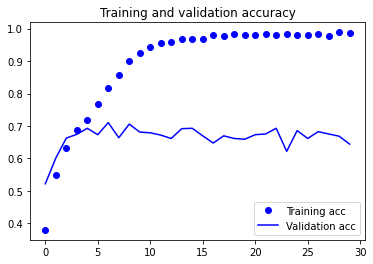

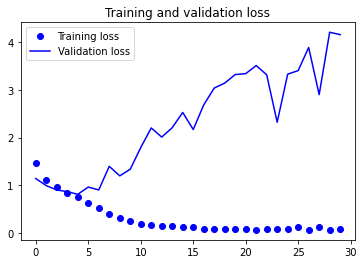

In [17]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Predicting the test set

Apply now your network to the test set

In [18]:
test_labels = test_generator.classes

In [19]:
pred_class = model.predict_classes(test_generator)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Report the accuracy as well as the classification report. Use sklearn functions

In [20]:
print(classification_report(test_labels, pred_class))

              precision    recall  f1-score   support

           0       0.62      0.62      0.62       144
           1       0.80      0.62      0.70       228
           2       0.47      0.64      0.54       165
           3       0.61      0.82      0.70       136
           4       0.61      0.42      0.49       192

    accuracy                           0.61       865
   macro avg       0.62      0.63      0.61       865
weighted avg       0.63      0.61      0.61       865



Print the confusion matrix

In [21]:
# Write your code here
print(confusion_matrix(test_labels, pred_class))

[[ 90  16  19  15   4]
 [ 26 142  11  31  18]
 [ 10   8 106  13  28]
 [ 10   6   6 112   2]
 [  9   6  83  14  80]]


Finally, run a model evaluation and store the loss and accuracy in the `test_loss_1` and `test_acc_1` variables. As with fitting, you may need to adjust the number of steps so that your network tests all the samples.

In [22]:
# Write your code here
test_loss_1, test_acc_1 = model.evaluate(test_generator)

44/44 [==============================] - 3s 75ms/step - loss: 4.4112 - accuracy: 0.6127


Try to improve your model by modifying some parameters and evaluate your network again.

## Using Image Augmentation

### Architecture

The flower dataset is relatively small. A way to expand such datasets is to generate artificial images by applying small transformations to existing images. Keras provides a built-in class for this: `ImageDataGenerator`. You will reuse it and apply it to the flower data set.
1. Using the network from the previous exercise, apply some transformations to your images. You can start from Chollet, Listing 5.11 (in notebook 5.2 also).
2. Report the training and validation losses and accuracies and comment on the possible overfit.
3. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.


Write a new generator for the training set

In [23]:
# Write your code here
datagen = ImageDataGenerator(rescale=1./255, # rescaling as we did before
      rotation_range=40, # rotating the images (degrees),
      width_shift_range=0.2, # translating images ,
      height_shift_range=0.2, # translating images,
      shear_range=0.2, # shearing transformations,
      zoom_range=0.2, # zooming,
      horizontal_flip=True, # flipping the images horizontally,
      fill_mode='nearest')#filling newly created pixels)

train_generator = datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(IMG_ROW, IMG_COL),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

# Same validation generator and test generator

Found 2593 images belonging to 5 classes.


Fit a model. You reset the model by recreating it.

In [24]:
# Recreating the exact same model

model = models.Sequential()


# Maybe we will need to change the parameters as we do not have binary classes as in the example
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(IMG_ROW, IMG_COL, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

In [25]:
# RMS Optimizer

model.compile(optimizer= OPTIMIZER ,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:


history = model.fit_generator(
      train_generator,
      steps_per_epoch=STEPS_PER_EPOCH,
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps=VALIDATION_STEPS)

Epoch 1/30
129/129 [==============================] - 27s 207ms/step - loss: 1.4651 - accuracy: 0.3634 - val_loss: 1.1909 - val_accuracy: 0.5686
Epoch 2/30
129/129 [==============================] - 26s 202ms/step - loss: 1.1467 - accuracy: 0.5336 - val_loss: 1.5078 - val_accuracy: 0.4837
Epoch 3/30
129/129 [==============================] - 26s 203ms/step - loss: 1.0411 - accuracy: 0.5911 - val_loss: 0.8081 - val_accuracy: 0.6977
Epoch 4/30
129/129 [==============================] - 26s 202ms/step - loss: 0.9659 - accuracy: 0.6281 - val_loss: 1.3111 - val_accuracy: 0.5430
Epoch 5/30
129/129 [==============================] - 26s 201ms/step - loss: 0.9322 - accuracy: 0.6382 - val_loss: 0.7936 - val_accuracy: 0.7151
Epoch 6/30
129/129 [==============================] - 26s 203ms/step - loss: 0.9076 - accuracy: 0.6518 - val_loss: 0.7882 - val_accuracy: 0.7221
Epoch 7/30
129/129 [==============================] - 26s 203ms/step - loss: 0.8915 - accuracy: 0.6685 - val_loss: 0.7474 - val_ac

### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

In [27]:
model.save('model_augmented_1')

INFO:tensorflow:Assets written to: model_augmented_1/assets


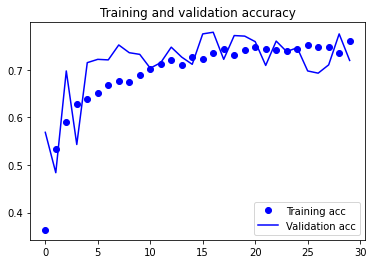

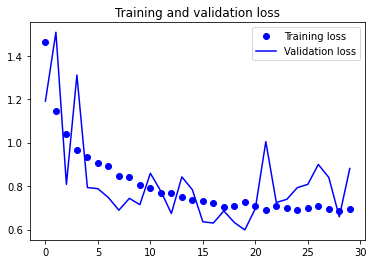

In [28]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Predicting the test set

Finally, run a model evaluation and store the loss and accuracy in the `test_loss_2` and `test_acc_2` variables.

In [29]:
test_labels = test_generator.classes
pred_class = model.predict_classes(test_generator)


In [30]:
print(classification_report(test_labels, pred_class))

              precision    recall  f1-score   support

           0       0.79      0.75      0.77       144
           1       0.91      0.61      0.73       228
           2       0.49      0.90      0.63       165
           3       0.74      0.92      0.82       136
           4       0.79      0.41      0.54       192

    accuracy                           0.69       865
   macro avg       0.74      0.72      0.70       865
weighted avg       0.75      0.69      0.69       865



In [31]:
print(confusion_matrix(test_labels, pred_class))

[[108   6  17   7   6]
 [ 20 140  35  25   8]
 [  6   2 148   4   5]
 [  1   3   5 125   2]
 [  2   3  99   9  79]]


In [32]:
test_loss_2, test_acc_2 = model.evaluate(test_generator)

44/44 [==============================] - 3s 75ms/step - loss: 0.9210 - accuracy: 0.6936


## Using a Pretrained Convolutional Base

### Architecture

Some research teams have trained convolutional neural networks on much larger datasets. We have seen during the lecture that the networks can model conceptual patterns as they go through the layers. This was identified by Le Cun in his first experiments [http://yann.lecun.com/exdb/lenet/](http://yann.lecun.com/exdb/lenet/). In this last part, you will train classifiers on top of a pretrained convolutional base.
1. Train your network and report the training and validation losses and accuracies.
2. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.

In [33]:
from keras.applications import VGG16, InceptionV3

In [34]:

if PRETRAINED == 'VGG':
    conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
else:
    conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
conv_base.summary()

87916544/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d_8[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________

As in Chollet, Listing 5.17 (in Chollet's notebook 5.3), you will program an `extract_features()` function.

In [35]:
datagen = ImageDataGenerator(rescale=1./255)

In [36]:
batch_size = 20

In [37]:

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 3, 3, 2048)) # Changed dim
    labels = np.zeros(shape=(sample_count,5)) # added ,5 as we have 5 different classes and not binary as in the example
    if directory == test_dir:
      generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = False)
    else:
      generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels


The features and labels

In [38]:
train_features, train_labels = extract_features(train_dir, len(train_generator.filenames))
validation_features, validation_labels = extract_features(validation_dir, len(validation_generator.filenames))
test_features, test_labels = extract_features(test_dir, len(test_generator.filenames))

Found 2593 images belonging to 5 classes.
Found 865 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


In [39]:
train_features = np.reshape(train_features, (train_features.shape[0], np.prod(train_features.shape[1:])))  # (2593, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (validation_features.shape[0], np.prod(validation_features.shape[1:]))) # (865, 4 * 4 * 512)
test_features = np.reshape(test_features, (test_features.shape[0], np.prod(test_features.shape[1:]))) # (865, 4 * 4 * 512))

Build a network that consists of the Inception V3 convolutional base and two dense layers.

In [40]:
model2 = models.Sequential()
model2.add(layers.Dense(256, activation='relu', input_dim=3 * 3 * 2048))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(5, activation='softmax'))

In [41]:
model2.compile(optimizer= OPTIMIZER ,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Fit your network

In [42]:
history = model2.fit(train_features, train_labels,
                    epochs=EPOCHS,
                    batch_size=batch_size,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
130/130 [==============================] - 1s 7ms/step - loss: 4.7373 - accuracy: 0.5488 - val_loss: 0.8653 - val_accuracy: 0.6601
Epoch 2/30
130/130 [==============================] - 1s 6ms/step - loss: 1.1635 - accuracy: 0.6525 - val_loss: 0.9725 - val_accuracy: 0.7052
Epoch 3/30
130/130 [==============================] - 1s 6ms/step - loss: 1.1418 - accuracy: 0.6876 - val_loss: 0.6163 - val_accuracy: 0.7954
Epoch 4/30
130/130 [==============================] - 1s 6ms/step - loss: 0.9051 - accuracy: 0.7316 - val_loss: 0.7222 - val_accuracy: 0.7884
Epoch 5/30
130/130 [==============================] - 1s 6ms/step - loss: 0.8621 - accuracy: 0.7617 - val_loss: 0.6154 - val_accuracy: 0.7931
Epoch 6/30
130/130 [==============================] - 1s 6ms/step - loss: 0.7991 - accuracy: 0.7759 - val_loss: 0.6067 - val_accuracy: 0.7965
Epoch 7/30
130/130 [==============================] - 1s 6ms/step - loss: 0.6415 - accuracy: 0.8029 - val_loss: 0.7472 - val_accuracy: 0.8173
Epoch 

### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

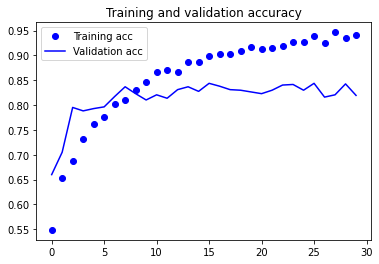

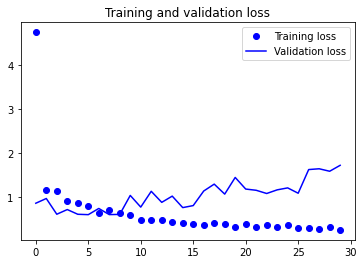

In [43]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Predicting the test set

Apply now your network to the test set

In [44]:

pred_class = model2.predict_classes(test_features)


Report the accuracy as well as the classification report. Use sklearn functions

In [45]:
ordered_labels = np.argmax(test_labels, axis = -1)

In [46]:
print(pred_class[:5])
print(ordered_labels[:5])

[0 0 0 0 3]
[0 0 0 0 0]


In [47]:
print(classification_report(ordered_labels, pred_class))


              precision    recall  f1-score   support

           0       0.86      0.80      0.83       144
           1       0.91      0.82      0.86       228
           2       0.88      0.66      0.75       165
           3       0.76      0.89      0.82       136
           4       0.71      0.89      0.79       192

    accuracy                           0.81       865
   macro avg       0.82      0.81      0.81       865
weighted avg       0.83      0.81      0.81       865



Print the confusion matrix

In [48]:
from sklearn import metrics

print(confusion_matrix(ordered_labels, pred_class))

[[115   6   2   9  12]
 [ 13 188   3  14  10]
 [  2   7 109   9  38]
 [  1   1   2 121  11]
 [  2   5   8   6 171]]


Finally, run a model evaluation and store the loss and accuracy in the `test_loss_3` and `test_acc_3` variables. As with fitting, you may need to adjust the number of steps so that your network tests all the samples.

In [49]:

test_loss_3, test_acc_3 = model2.evaluate(test_features,test_labels)

28/28 [==============================] - 0s 3ms/step - loss: 1.9432 - accuracy: 0.8139


## Using a Pretrained Convolutional Base with Image Augmentation

### Architecture

1. Modify your program to include an image transformer. Train a new model. As a hint, you can make the whole convolutional base trainable and use the stochastic gradient descent as optimizer.
2. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.

In [50]:
if PRETRAINED == 'VGG':
    conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
else:
    conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_102 (Conv2D)             (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_102[0][0]                 
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

Create the generators

In [51]:


train_datagen = ImageDataGenerator(
      rescale =1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1. / 255)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        # This is the target directory
        test_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical',
        shuffle = False )


Found 2593 images belonging to 5 classes.
Found 865 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


Fit the model

In [52]:
model = models.Sequential()

conv_base.trainable = False

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 1285      
Total params: 26,522,917
Trainable params: 4,720,133
Non-trainable params: 21,802,784
_________________________________________________________________


In [53]:
model.compile(optimizer=OPTIMIZER,
              loss='categorical_crossentropy',
              metrics=['acc'])

In [54]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=STEPS_PER_EPOCH,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=VALIDATION_STEPS)


Epoch 1/30
129/129 [==============================] - 29s 221ms/step - loss: 5.7193 - acc: 0.5577 - val_loss: 1.0560 - val_acc: 0.7081
Epoch 2/30
129/129 [==============================] - 27s 211ms/step - loss: 1.3526 - acc: 0.6883 - val_loss: 0.8117 - val_acc: 0.7233
Epoch 3/30
129/129 [==============================] - 27s 206ms/step - loss: 0.8379 - acc: 0.7213 - val_loss: 0.6125 - val_acc: 0.7756
Epoch 4/30
129/129 [==============================] - 27s 212ms/step - loss: 0.7053 - acc: 0.7586 - val_loss: 0.8148 - val_acc: 0.7442
Epoch 5/30
129/129 [==============================] - 27s 211ms/step - loss: 0.7001 - acc: 0.7513 - val_loss: 0.5455 - val_acc: 0.8070
Epoch 6/30
129/129 [==============================] - 27s 212ms/step - loss: 0.6325 - acc: 0.7944 - val_loss: 0.4847 - val_acc: 0.8291
Epoch 7/30
129/129 [==============================] - 27s 213ms/step - loss: 0.6104 - acc: 0.7952 - val_loss: 0.5408 - val_acc: 0.8140
Epoch 8/30
129/129 [==============================] - 2

### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

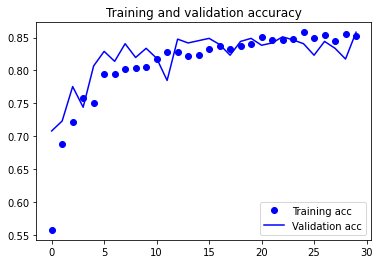

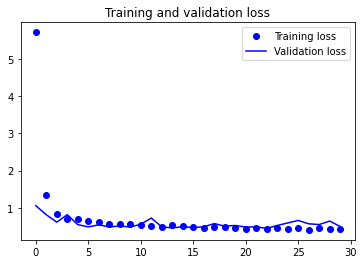

In [55]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Predicting the test set

Apply now your network to the test set

In [56]:
pred_class = model.predict_classes(test_generator)
test_labels = test_generator.classes

In [57]:
print(pred_class[:5])
print(test_labels[:5])

[0 0 0 0 0]
[0 0 0 0 0]


Report the accuracy as well as the classification report. Use sklearn functions

In [58]:
print(classification_report(pred_class, test_labels))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       141
           1       0.85      0.91      0.88       214
           2       0.77      0.81      0.79       157
           3       0.90      0.78      0.84       157
           4       0.82      0.80      0.81       196

    accuracy                           0.84       865
   macro avg       0.84      0.83      0.84       865
weighted avg       0.84      0.84      0.84       865



Print the confusion matrix

In [59]:
print(confusion_matrix(pred_class, test_labels))


[[123  11   2   2   3]
 [  6 194   4   5   5]
 [  4   1 127   4  21]
 [  7  14   7 123   6]
 [  4   8  25   2 157]]


Finally, run a model evaluation and store the loss and accuracy in the `test_loss_4` and `test_acc_4` variables. As with fitting, you may need to adjust the number of steps so that your network tests all the samples.

In [60]:
# Write your code
test_loss_4, test_acc_4 = model.evaluate(test_generator)

44/44 [==============================] - 4s 82ms/step - loss: 0.5598 - acc: 0.8370


## Passing the Assignment

To pass the assignment, you need to reach an accuracy of 75 (even 80 ideally) with your best network.

In [61]:
(test_loss_1, test_acc_1), (test_loss_2, test_acc_2), (test_loss_3, test_acc_3), (test_loss_4, test_acc_4)

((4.411196231842041, 0.6127167344093323),
 (0.9209669232368469, 0.6936416029930115),
 (1.9431697130203247, 0.8138728141784668),
 (0.5598387122154236, 0.8369942307472229))

## Report

You will write a short report of about two pages on your experiments:
1. You will describe the architectures you designed and the results you obtained;
2. You will run Chollet's notebook 5.4 and read the article _Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization_ by Selvaraju et al. From this, you will reformulate and comment the paragraph on _Visualizing heatmaps of class activation_ in the notebook. 
3. You will run it on one of your images.

You will submit this report through Canvas.